In [ ]:
%pip install pandas
%pip install influxdb_client
%pip install cmdstanpy==0.9.68
%pip install pystan==2.19.1.1
%pip install seaborn
%pip install prophet

### Get data from influx db
based on https://github.com/influxdata/influxdb-client-python/blob/master/examples/

In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [15]:
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
#read influx info from config file

fd =  open('../../server/config.json', 'r')
config = json.load(fd)
query_temp = 'from(bucket:"temp")' \
        ' |> range(start: -4h)'\
        ' |> filter(fn: (r) => r._measurement == "val" and r._field == "value")'
client =  InfluxDBClient(url='http://'+config["influx"]["remotehost"]+':'+config["influx"]["port"], token=config["influx"]["token"], org=config["influx"]["org"], debug=False)
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()  
result = query_api.query_data_frame(query_temp)

fd.close()

In [16]:
df = result.drop(columns=['result', 'table', '_start', '_stop', '_field', '_measurement'])

In [17]:
df_clean = df.copy()
df_clean = df_clean.loc[df_clean['sensor'] == '0']
df_clean = df_clean.drop(columns=['lat', 'lon', 'sensor'])
df_clean = df_clean.rename(columns = {'_time': 'Time', '_value': 'y'})
df_clean['Time'] = df_clean['Time'].dt.strftime('%d-%m-%Y %H:%M:%S')
df_clean

,Time,y
0,14-06-2022 09:39:52,49.900002
1,14-06-2022 09:40:02,50.000000
2,14-06-2022 09:40:12,50.000000
3,14-06-2022 09:40:22,50.000000
4,14-06-2022 09:40:33,50.000000
...,...,...
1604,14-06-2022 13:39:09,43.400002
1605,14-06-2022 13:39:17,43.200001
1606,14-06-2022 13:39:24,43.500000
1607,14-06-2022 13:39:32,43.400002


In [18]:
#temperature changing in time, 6 hours for now, i'll try to get an entire day this time
#if i don't save temp as a variable it will plot with the time as xtick and it's bad
plot_cols = ['Temp']
plot_features = df_clean[plot_cols]
_ = plot_features.plot(subplots=True)

KeyError: "None of [Index(['Temp'], dtype='object')] are in the [columns]"

In [10]:
df_clean.describe().transpose()
#pretty stationary in the end, just wait for the day
#basically with the year it should become almost stationary

,count,mean,std,min,25%,50%,75%,max
Temp,4270.0,26.180304,0.448781,25.4,25.9,26.0,26.4,27.200001


In [11]:
###stationary test
from statsmodels.tsa.stattools import adfuller
#split dataset
l = len(df_clean.values)
splitpoint = int(l*0.80)
train = df_clean['Temp'][:splitpoint]
test = df_clean['Temp'][splitpoint:]


In [12]:
res = adfuller(train)
print('ADF val: ', res[0], 'p-value:', res[1])

ADF val:  -0.7725218841532071 p-value: 0.827060621098382


In [13]:
#if p-val < 0.05 then series is stationary, if not i have to do some magic -> 0.83977
train_diff = train.diff().dropna()
res = adfuller(train_diff)
print('ADF val: ', res[0], 'p-value:', res[1])


ADF val:  -9.846400988807737 p-value: 4.6073117913846903e-17


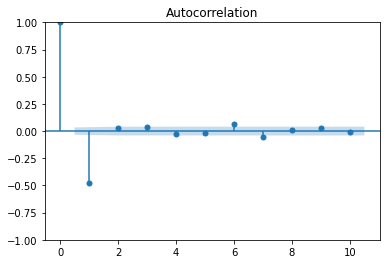

In [14]:
#holy shit that's low holy moly
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train_diff, lags=10)
plt.show()

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


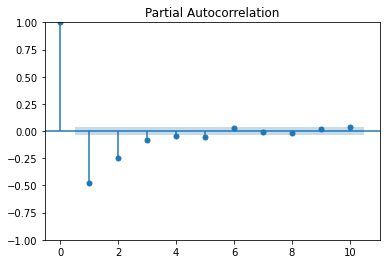

In [15]:
#partial autocorrelation -> find q that is the highest with the minimal difference from the deviation(?) 
fig = tsaplots.plot_pacf(train_diff, lags=10)
plt.show()

In [17]:
#once you have both p and q it is possibile to apply the ARIMA model
from statsmodels.tsa.arima.model import ARIMA
history = [x for x in train]
predictions = list()
for t in test.index:
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yest = output[0]
    predictions.append(yest)
    obs= test[t]
    history.append(obs)

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 0.037


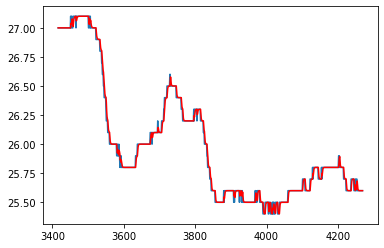

In [18]:
#plt
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd.DataFrame(predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show( )

In [51]:
df_clean.to_csv('hum_2.csv')

### Humidity predictor


In [24]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
#read influx info from config file

fd =  open('../../server/config.json', 'r')
config = json.load(fd)
query_hum = 'from(bucket:"hum")' \
        ' |> range(start:-3h)'\
        ' |> filter(fn: (r) => r._measurement == "val" and r._field == "value")'
client =  InfluxDBClient(url='http://'+config["influx"]["remotehost"]+':'+config["influx"]["port"], token=config["influx"]["token"], org=config["influx"]["org"], debug=False)
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()  
result = query_api.query_data_frame(query_hum)

fd.close()
df = result.drop(columns=['result', 'table', '_start', '_stop', '_field', '_measurement'])
df_clean = df.copy()
df_clean = df_clean.loc[df_clean['sensor'] == '0']
df_clean = df_clean.drop(columns=['lat', 'lon', 'sensor'])
df_clean = df_clean.rename(columns = {'_time': 'Time', '_value': 'Hum'})
df_clean['Time'] = df_clean['Time'].dt.strftime('%d-%m-%Y %H:%M:%S')
df_clean

,Time,Hum
0,14-06-2022 10:40:43,45.500000
1,14-06-2022 10:40:53,45.500000
2,14-06-2022 10:41:03,45.500000
3,14-06-2022 10:41:13,45.400002
4,14-06-2022 10:41:23,45.400002
...,...,...
1246,14-06-2022 13:39:56,43.700001
1247,14-06-2022 13:40:05,43.700001
1248,14-06-2022 13:40:13,43.599998
1249,14-06-2022 13:40:21,43.599998


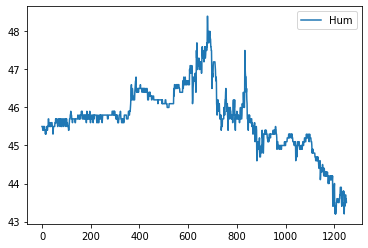

In [25]:
plot_cols = ['Hum']
plot_features = df_clean[plot_cols]
_ = plot_features.plot(subplots=True)

In [26]:
df_clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Hum,1251.0,45.68689,0.848983,43.200001,45.299999,45.700001,46.200001,48.400002


In [27]:
###stationary test
from statsmodels.tsa.stattools import adfuller
#split dataset
l = len(df_clean.values)
splitpoint = int(l*0.80)
train = df_clean['Hum'][:splitpoint]
test = df_clean['Hum'][splitpoint:]


In [28]:
res = adfuller(train)
print('ADF val: ', res[0], 'p-value:', res[1])

ADF val:  -2.189770426799759 p-value: 0.2099791291245428


In [29]:
#if p-val < 0.05 then series is stationary, if not i have to do some magic -> 0.83977
train_diff = train.diff().dropna()
res = adfuller(train_diff)
print('ADF val: ', res[0], 'p-value:', res[1])

ADF val:  -12.191197152643563 p-value: 1.2845911294537847e-22


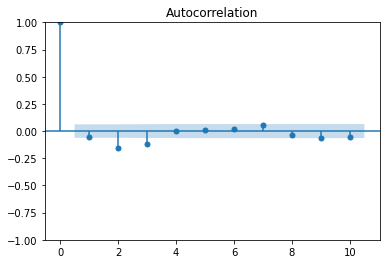

In [30]:
#holy shit that's low holy moly
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train_diff, lags=10)
plt.show()

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


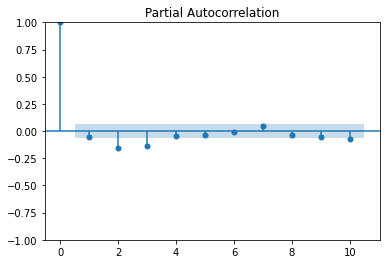

In [31]:
#partial autocorrelation -> find q that is the highest with the minimal difference from the deviation(?) 
fig = tsaplots.plot_pacf(train_diff, lags=10)
plt.show()

In [46]:
#once you have both p and q it is possibile to apply the ARIMA model
from statsmodels.tsa.arima.model import ARIMA
history = [x for x in train]
predictions = list()
for t in test.index:
  model = ARIMA(history, order=(2,2,1)) #d is the number of time that the raw values are differentiated
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\franc\AppData\Local\Packages\Pytho

Test RMSE: 0.198


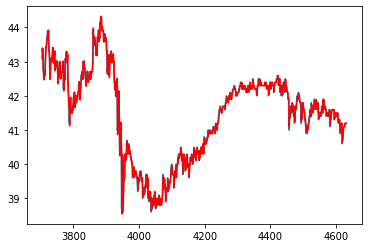

In [47]:
#plt
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show( )

### Smoke Predictor

In [52]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
#read influx info from config file

fd =  open('../../server/config.json', 'r')
config = json.load(fd)

query_smoke = 'from(bucket:"smoke")' \
        ' |> range(start:-8h)' \
        ' |> filter(fn: (r) => r._measurement == "val" and r._field == "value")'
client =  InfluxDBClient(url='http://'+config["influx"]["remotehost"]+':'+config["influx"]["port"], token=config["influx"]["token"], org=config["influx"]["org"], debug=False)
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()  
result = query_api.query_data_frame(query_smoke)

fd.close()
df = result.drop(columns=['result', 'table', '_start', '_stop', '_field', '_measurement'])
df_clean = df.copy()
df_clean = df_clean.loc[df_clean['sensor'] == '0']
df_clean = df_clean.drop(columns=['lat', 'lon', 'sensor'])
df_clean = df_clean.rename(columns = {'_time': 'Time', '_value': 'Smoke'})
df_clean['Time'] = df_clean['Time'].dt.strftime('%d-%m-%Y %H:%M:%S')
df_clean

,Time,Smoke
0,09-06-2022 06:08:25,8.375093
1,09-06-2022 06:08:30,8.170989
2,09-06-2022 06:08:35,7.580606
3,09-06-2022 06:08:40,6.202382
4,09-06-2022 06:08:50,7.997087
...,...,...
4694,09-06-2022 13:58:58,1.444317
4695,09-06-2022 13:59:08,1.457014
4696,09-06-2022 13:59:18,1.506000
4697,09-06-2022 13:59:28,1.503392


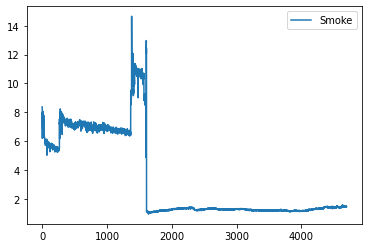

In [53]:
plot_cols = ['Smoke']
plot_features = df_clean[plot_cols]
_ = plot_features.plot(subplots=True)

In [54]:
df_clean.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Smoke,4699.0,3.354158,3.004695,0.969425,1.231373,1.338392,6.736728,14.65192


In [63]:
###stationary test
from statsmodels.tsa.stattools import adfuller
#split dataset
l = len(df_clean.values)
splitpoint = int(l*0.80)
train = df_clean['Smoke'][:splitpoint]
test = df_clean['Smoke'][splitpoint:]

In [64]:
res = adfuller(train)
print('ADF val: ', res[0], 'p-value:', res[1])

ADF val:  -1.559988923068363 p-value: 0.5036549029393126


In [65]:
#if p-val < 0.05 then series is stationary, if not i have to do some magic -> 0.83977
train_diff = train.diff().dropna()
res = adfuller(train_diff)
print('ADF val: ', res[0], 'p-value:', res[1])

ADF val:  -19.925596170130643 p-value: 0.0


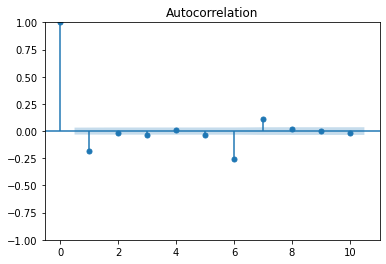

In [58]:
#holy shit that's low holy moly
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train_diff, lags=10)
plt.show()

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


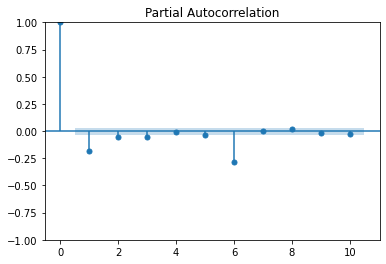

In [59]:
#partial autocorrelation -> find q that is the highest with the minimal difference from the deviation(?) 
fig = tsaplots.plot_pacf(train_diff, lags=10)
plt.show()

In [66]:
#once you have both p and q it is possibile to apply the ARIMA model
from statsmodels.tsa.arima.model import ARIMA
history = [x for x in train]
predictions = list()
for t in test.index:
  model = ARIMA(history, order=(1,1,1)) #d is the number of time that the raw values are differentiated
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)

Test RMSE: 0.028


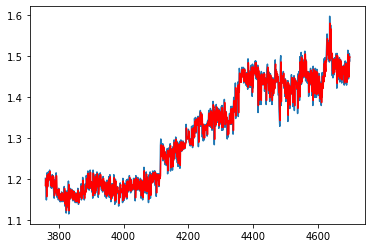

In [67]:
#plt
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd.DataFrame(predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show( )